In [1]:
using Dates; now()

2019-03-24T14:08:33.051

In [2]:
# load packages
using Revise, MathematicalSystems, LazySets, Reachability, TaylorIntegration
using Reachability: solve
using Plots

## 2D circle model

Defining the model:

$$
x' = y\\~~y' = -x
$$

In [3]:
A = [0 1.; -1 0]
X0 = BallInf(ones(2), 0.1)
problem = InitialValueProblem(LinearContinuousSystem(A), X0)

dump(problem)

InitialValueProblem{LinearContinuousSystem{Float64,Array{Float64,2}},BallInf{Float64}}
  s: LinearContinuousSystem{Float64,Array{Float64,2}}
    A: Array{Float64}((2, 2)) [0.0 1.0; -1.0 0.0]
  x0: BallInf{Float64}
    center: Array{Float64}((2,)) [1.0, 1.0]
    radius: Float64 0.1


**Solution using `BFFPSV18` algorithm.**

Computing successors 100%|██████████████████████████████| Time: 0:00:02


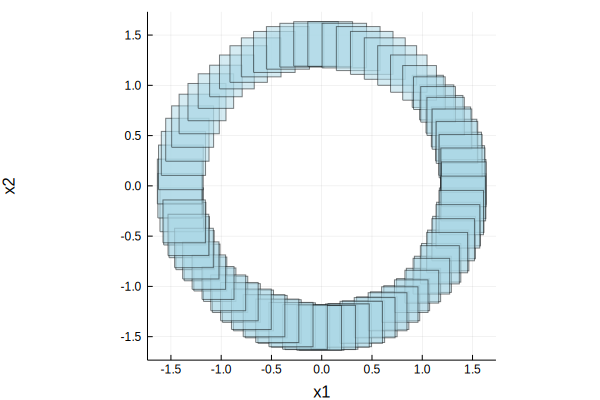

In [4]:
sol_BFFPSV18 = solve(problem, Options(:T=>10.0, :plot_vars=>[1, 2]), op=BFFPSV18(:δ=>0.1));

plot(sol_BFFPSV18, use_subindices=false, aspectratio=1, alpha=.5, color=:lightblue)

In [5]:
@btime solve($problem, Options(:T=>10.0, :plot_vars=>[1, 2]), op=BFFPSV18(:δ=>0.1));

  13.286 ms (9605 allocations: 718.39 KiB)


**Solution using `TMJets` algorithm.**

First we need to write the system in the form `x'(t) = f(x(t))`. Since the ODE is given by an anonymous function, the stateset is unconstrained and there are no inputs, we can use a [BlackBoxContinuousSystem](https://juliareach.github.io/MathematicalSystems.jl/latest/lib/types/#MathematicalSystems.BlackBoxContinuousSystem).

In [6]:
@taylorize function circle!(t, x, dx)
    dx[1] = x[2]
    dx[2] = -x[1]
end

f = BlackBoxContinuousSystem(circle!, 2)
problem = InitialValueProblem(f, X0)

InitialValueProblem{BlackBoxContinuousSystem{typeof(circle!)},BallInf{Float64}}(BlackBoxContinuousSystem{typeof(circle!)}(circle!, 2), BallInf{Float64}([1.0, 1.0], 0.1))

In [17]:
@time sol_TMJets = solve(problem, Options(:T=>10.0, :plot_vars=>[1, 2]),
                         op=TMJets(:orderT=>7, :orderQ=>1, :abs_tol=>1e-11));

  0.633949 seconds (9.93 M allocations: 564.817 MiB, 26.42% gc time)


In [18]:
@btime sol_TMJets = solve($problem, Options(:T=>10.0, :plot_vars=>[1, 2]),
                          op=TMJets(:orderT=>7, :orderQ=>1, :abs_tol=>1e-11));

  624.873 ms (9926852 allocations: 564.82 MiB)


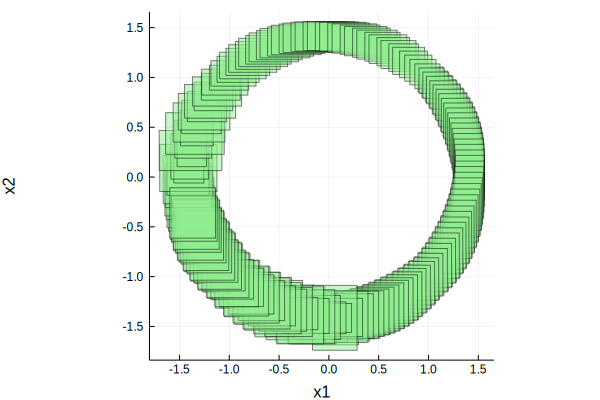

In [19]:
plot(sol_TMJets, use_subindices=false, aspectratio=1, alpha=.5, color=:lightgreen)

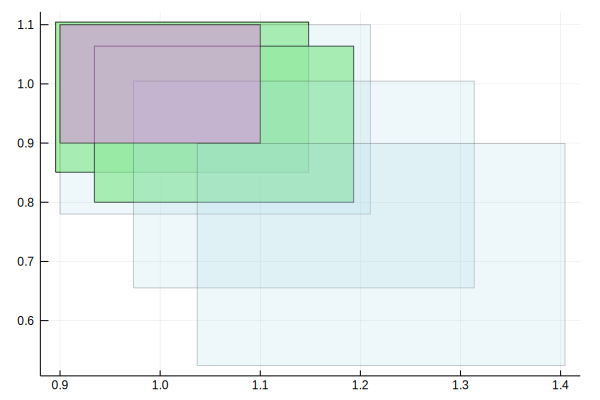

In [10]:
plot([sol_TMJets.Xk[i].X for i in 1:3], color=:lightgreen, alpha=.8)
plot!([sol_BFFPSV18.Xk[i].X for i in 1:3], color=:lightblue, alpha=.2)
plot!(X0, color=:violet, alpha=0.5)

Plot in the same pair of axes the solutions obtained with each algorithm:

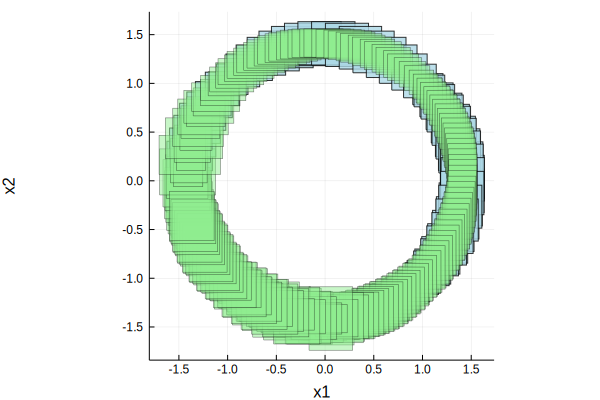

In [11]:
plot(sol_BFFPSV18, use_subindices=false, aspectratio=1, alpha=.8, color=:lightblue)
plot!(sol_TMJets, use_subindices=false, aspectratio=1, alpha=.5, color=:lightgreen, lw=0.6)